Ex. 1
In this exercise we verify numerically the purpose of the leverage scores discussed
in class. Generate a random linear model y = ax1 + b + ϵ where ϵ is random
Gaussian noise with mean μ and variance σ2. For various values of μ, σ2 generate
data and compute the leverage scores for all the points. Create four types of
points: regular (low noise, close to the model), high variance on x, high variance
on y and finally high variance on both x and y. Plot all results, group in subplots
for the various values of noise variance. Mark on the plots the points with the
highest leverage scores. Repeat the exercise for the 2D case y = ax1 +bx2 +c+ϵ.

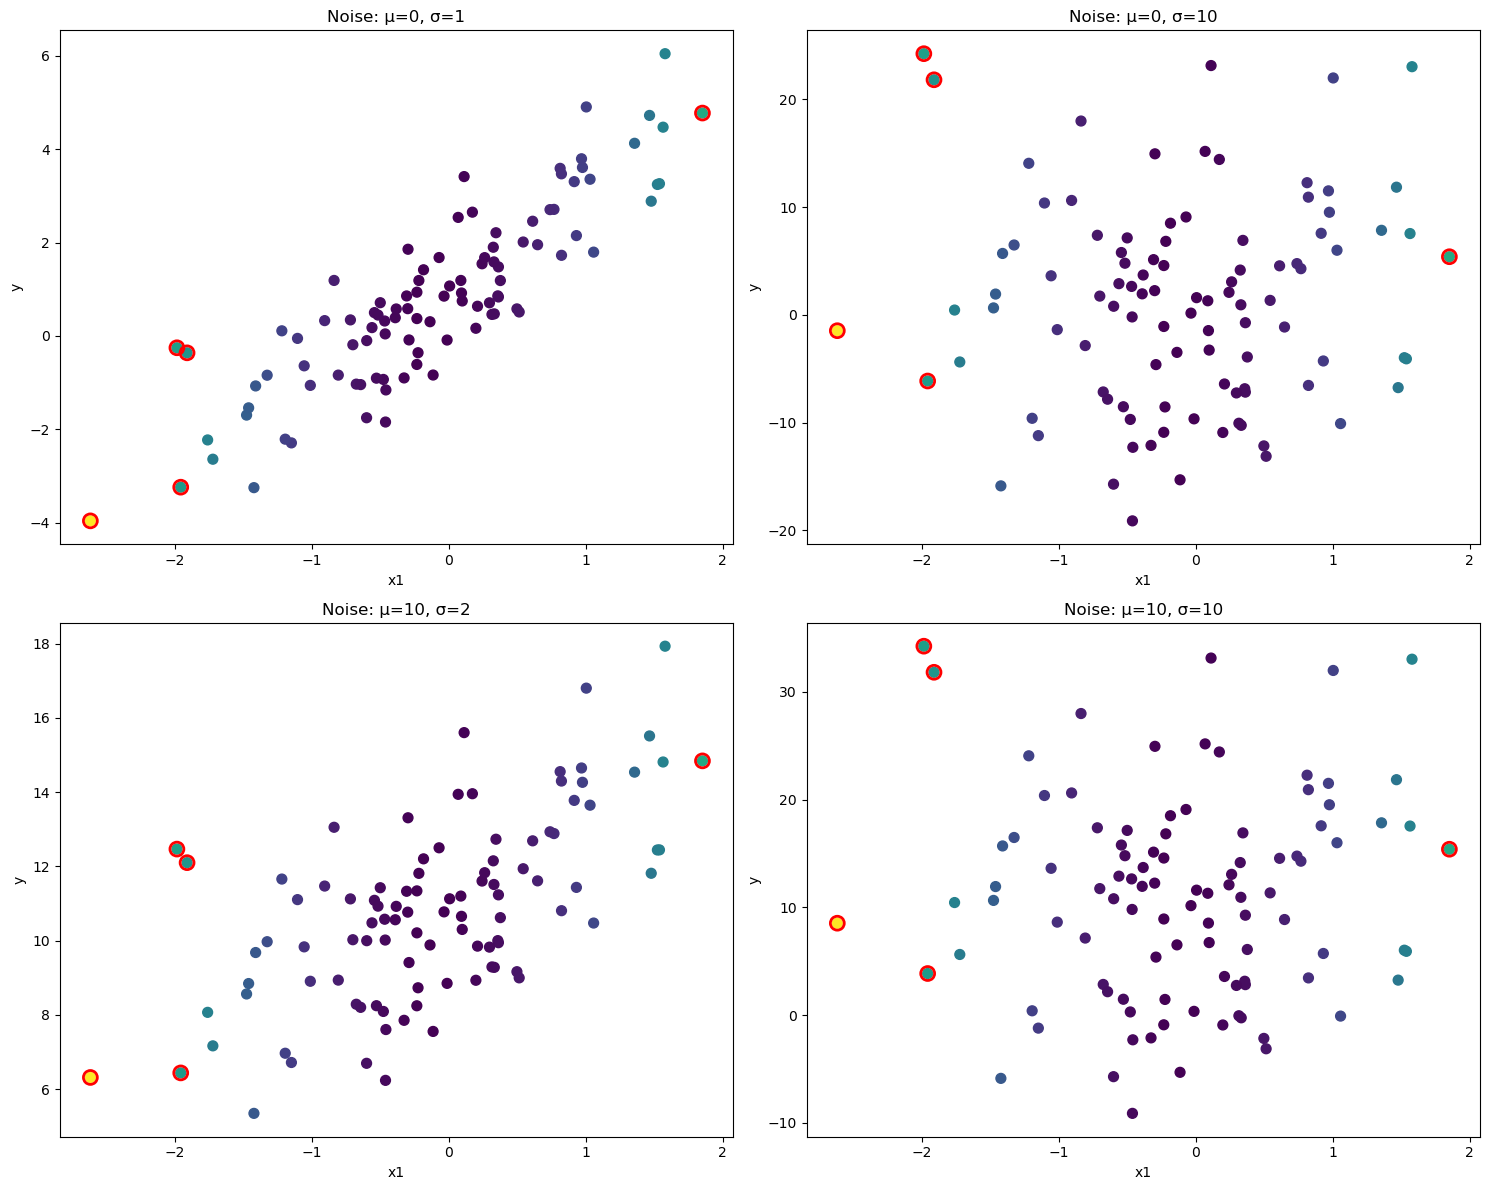

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def leverage_scores(X):
    U, Sigma, Vt = np.linalg.svd(X, full_matrices=False)  # u = 5, 5; sigma = 2, ; Vt = 2, 2
    p = X.shape[1]
    lev_scores = np.sum(U[:, :p]**2, axis=1)
    return lev_scores


def generate_data_1d(n, a, b, mu, sigma):
    np.random.seed(42)
    x1 = np.random.randn(n)
    y = a * x1 + b + np.random.normal(mu, sigma, n)
    X = np.vstack([np.ones(n), x1]).T
    lev_scores = leverage_scores(X)
    return x1, y, lev_scores


n, a, b = 100, 2, 1  
noise_levels = [(0, 1), (0, 10), (10, 2), (10, 10)]  
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt_i = 0
plt_j = 0
for i, (mu, sigma) in enumerate(noise_levels):
    x1, y, lev_scores = generate_data_1d(n, a, b, mu, sigma)
    ax = axes[plt_i, plt_j]
    if i%2 == 0:
        plt_j += 1
    else:
        plt_i += 1
        plt_j = 0
    ax.scatter(x1, y, c=lev_scores, cmap='viridis', s=50)
            
    # Highlight the highest leverage points
    high_lev_idx = np.argsort(lev_scores)[-5:]
    ax.scatter(x1[high_lev_idx], y[high_lev_idx], edgecolor='red', s=100, facecolor='none', linewidth=2)
            
    ax.set_title(f"Noise: μ={mu}, σ={sigma}")
    ax.set_xlabel('x1')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

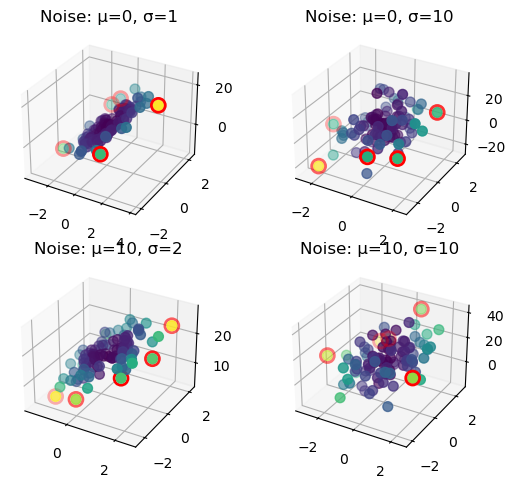

In [2]:
def generate_data_2d(n, a, b, c, mu, sigma):
    x1 = np.random.randn(n)
    x2 = np.random.randn(n)
    y = a * x1 + b * x2 + c + np.random.normal(mu, sigma, n)
    X = np.vstack([np.ones(n), x2, x1]).T
    lev_scores = leverage_scores(X)
    return x1, x2, y, lev_scores

n, a, b, c = 100, 5, 2, 4  
noise_levels = [(0, 1), (0, 10), (10, 2), (10, 10)]
plt_i = 1
plt_j = 1   
fig = plt.figure(figsize=plt.figaspect(0.8))
for i, (mu, sigma) in enumerate(noise_levels):
    x1, x2, y, lev_scores = generate_data_2d(n, a, b, c, mu, sigma)
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(x1, x2, y, c=lev_scores, cmap='viridis', s=50)
            
    # Highlight the highest leverage points
    high_lev_idx = np.argsort(lev_scores)[-5:]
    ax.scatter(x1[high_lev_idx], x2[high_lev_idx], y[high_lev_idx], edgecolor='red', s=100, facecolor='none', linewidth=2)
            
    ax.set_title(f"Noise: μ={mu}, σ={sigma}")

plt.tight_layout()
plt.show()

Ex. 2
Using the function generate data clusters generate a 2-dimensional dataset
with 400 train samples and 200 test samples that are organized in 2 clusters,
with 0.1 contamination. Train a KNN model from pyod.models.knn. Use 4
subplots in order to display using different colors (for inliers and outliers):
• Ground truth labels for training data
• Predicted labels for training data
• Ground truth labels for test data
• Predicted labels for test data
Use different values for the n neighbors parameter and observe how this
affects the detection of small clusters of anomalies. Also compute the balanced
accuracy for each parameter.

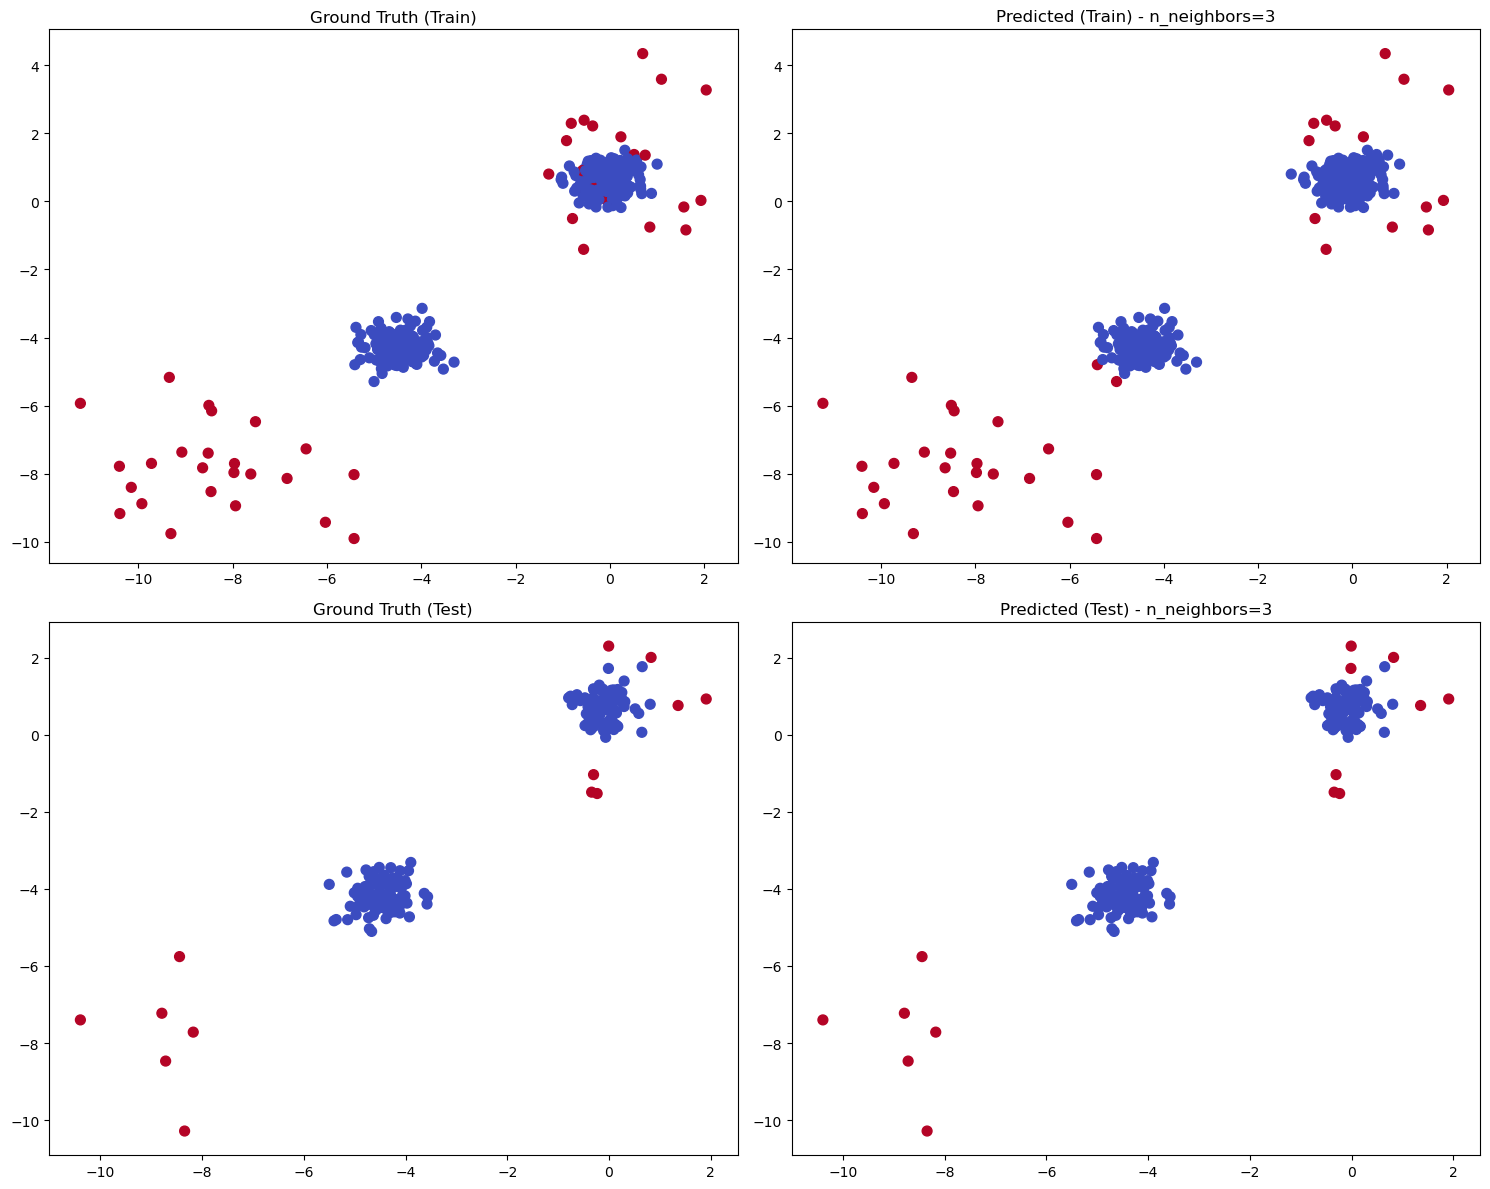

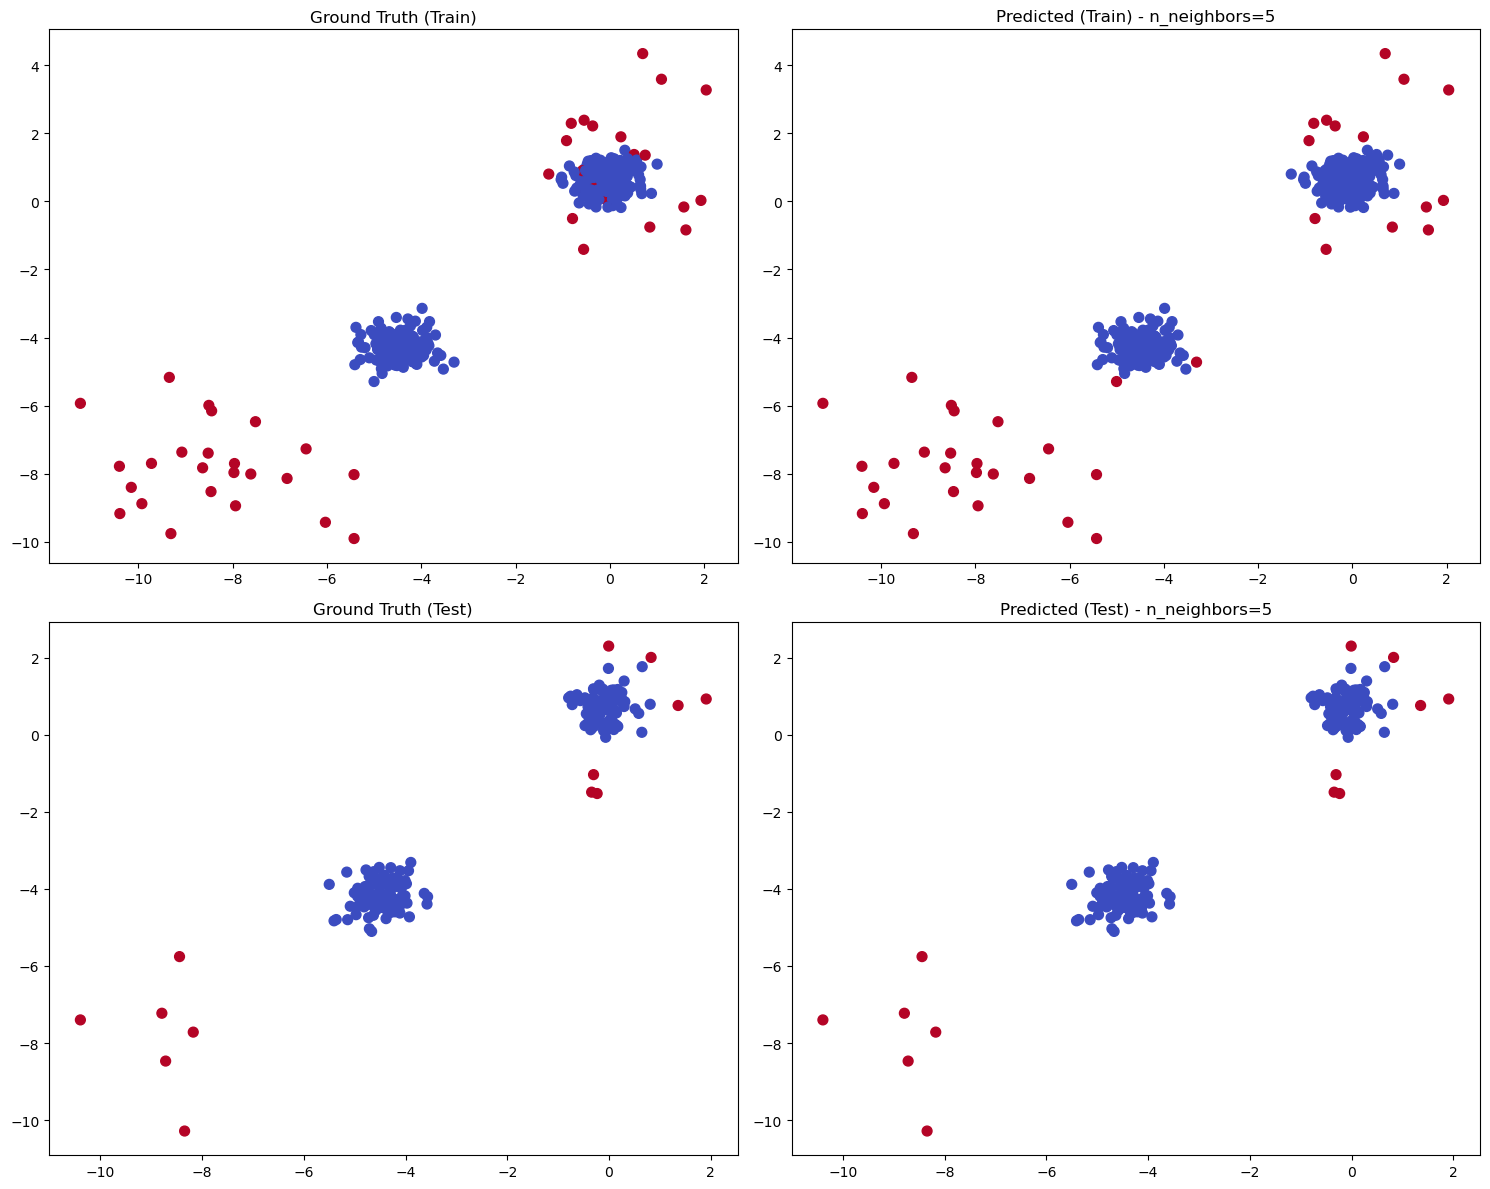

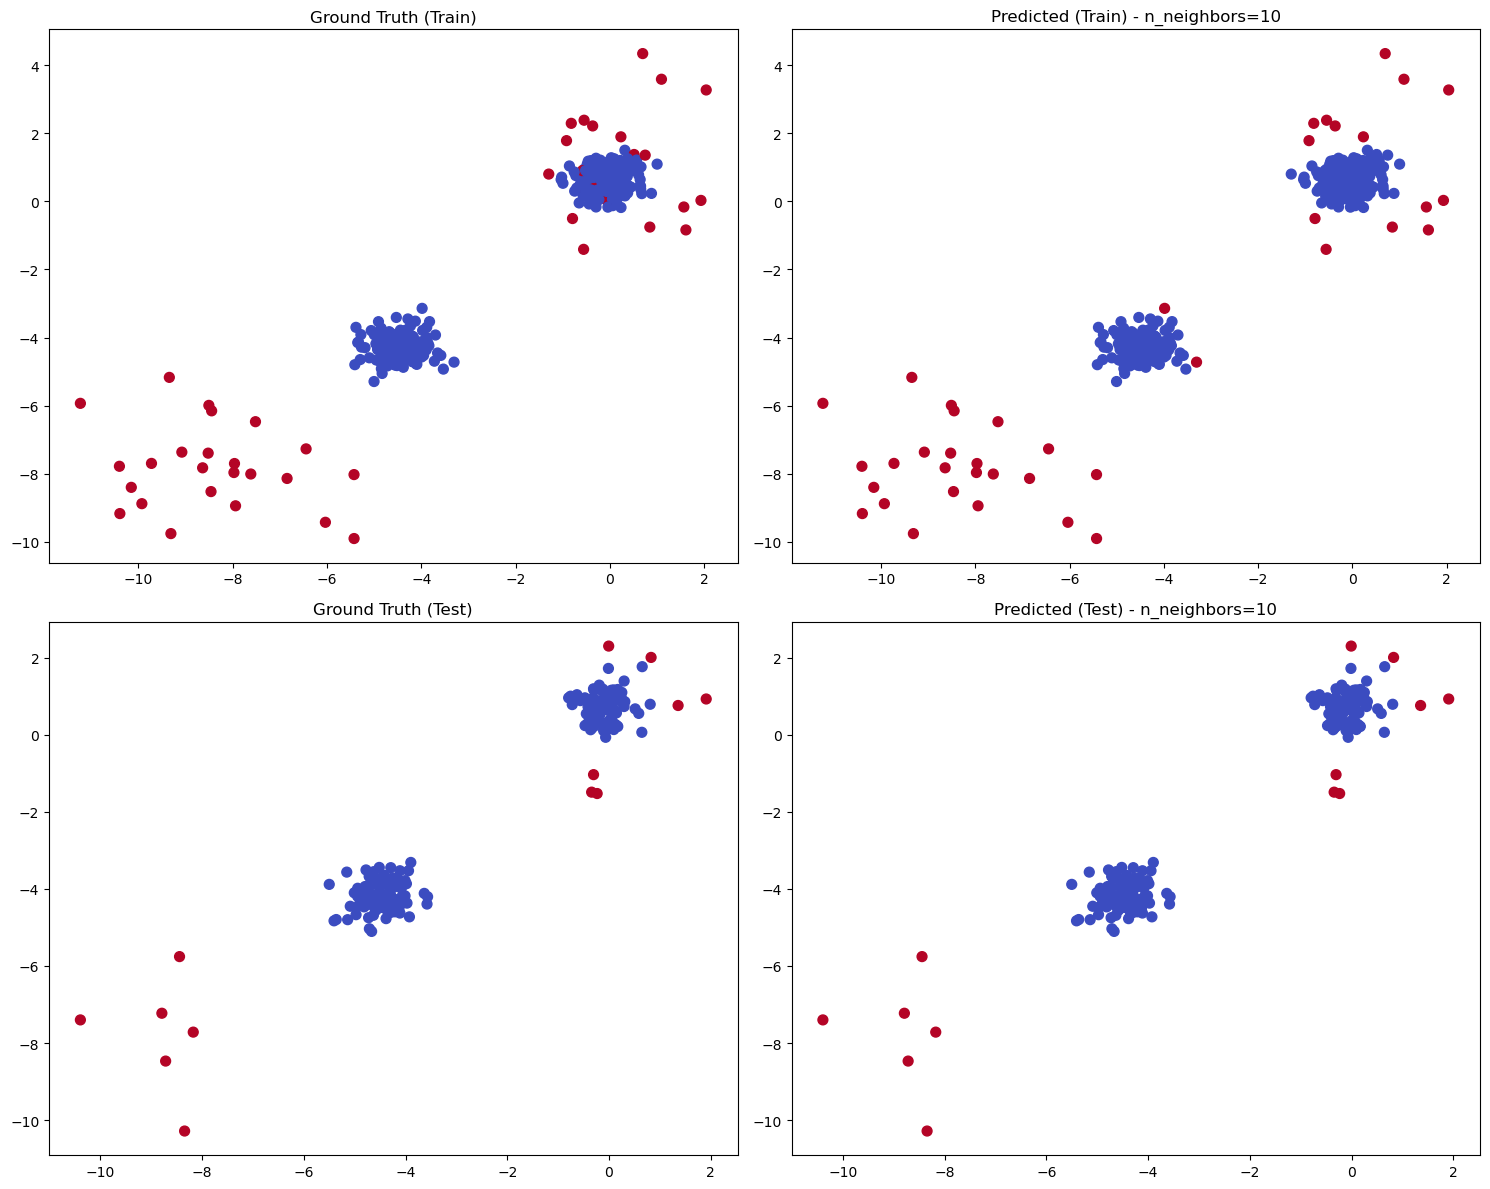

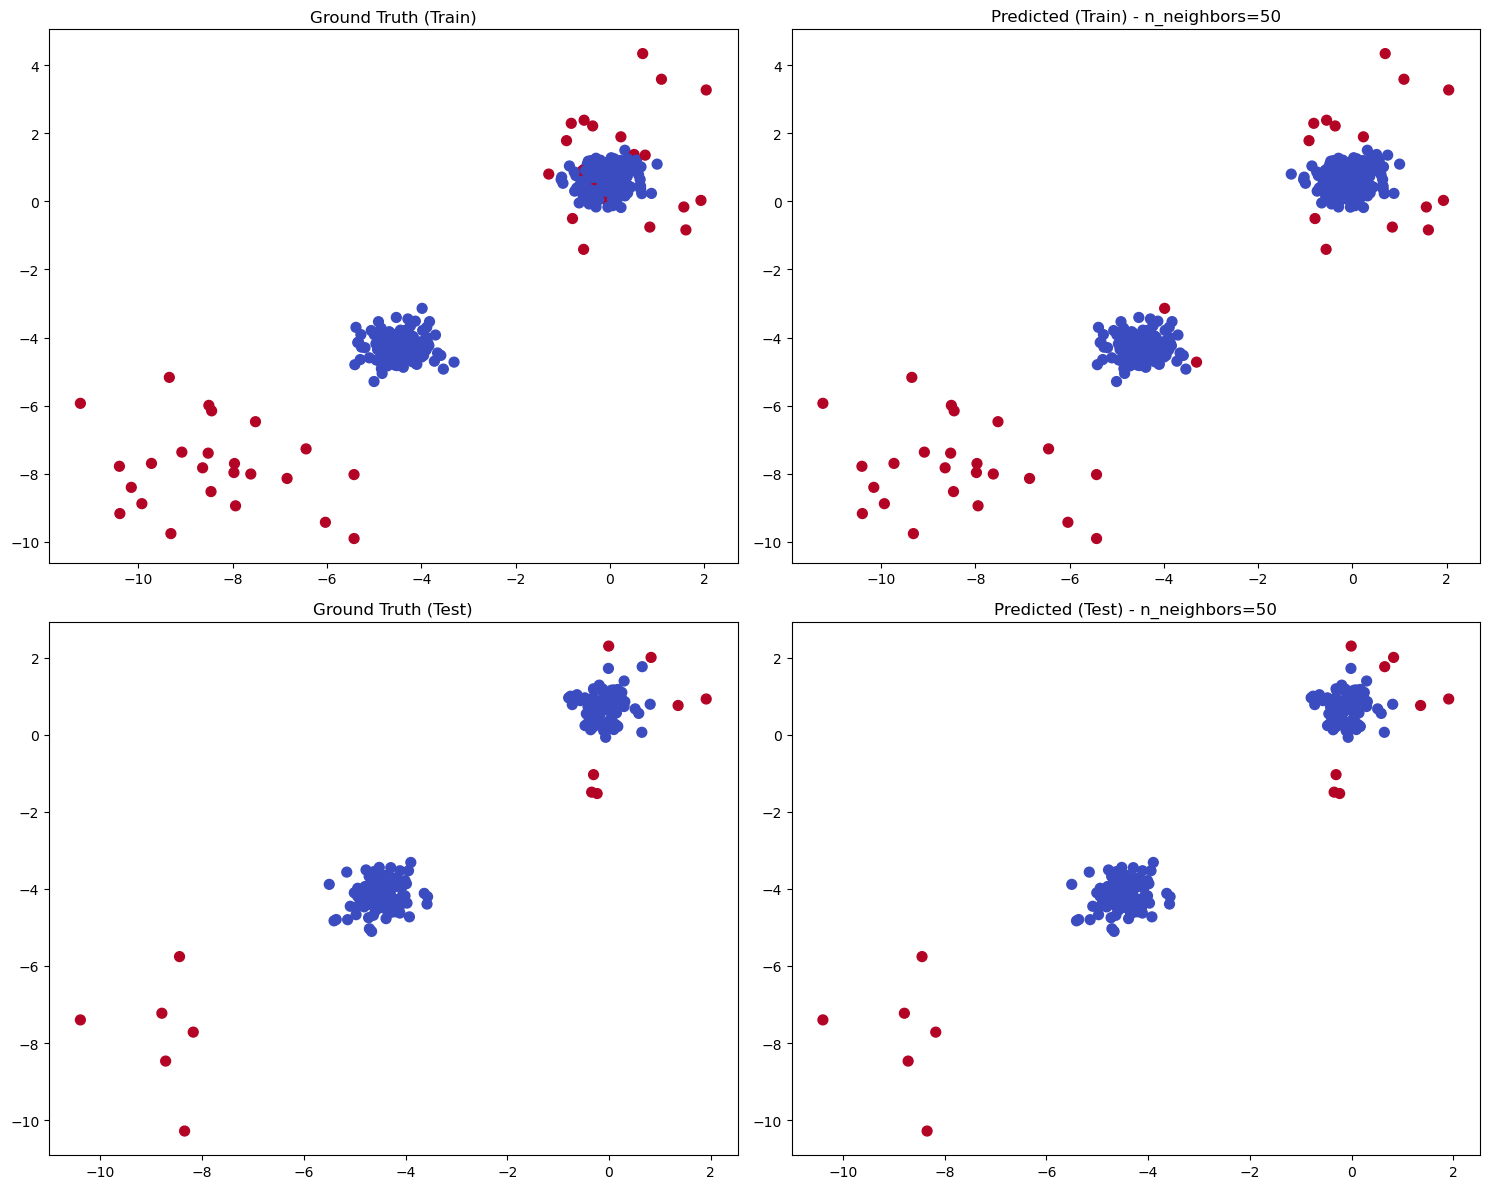

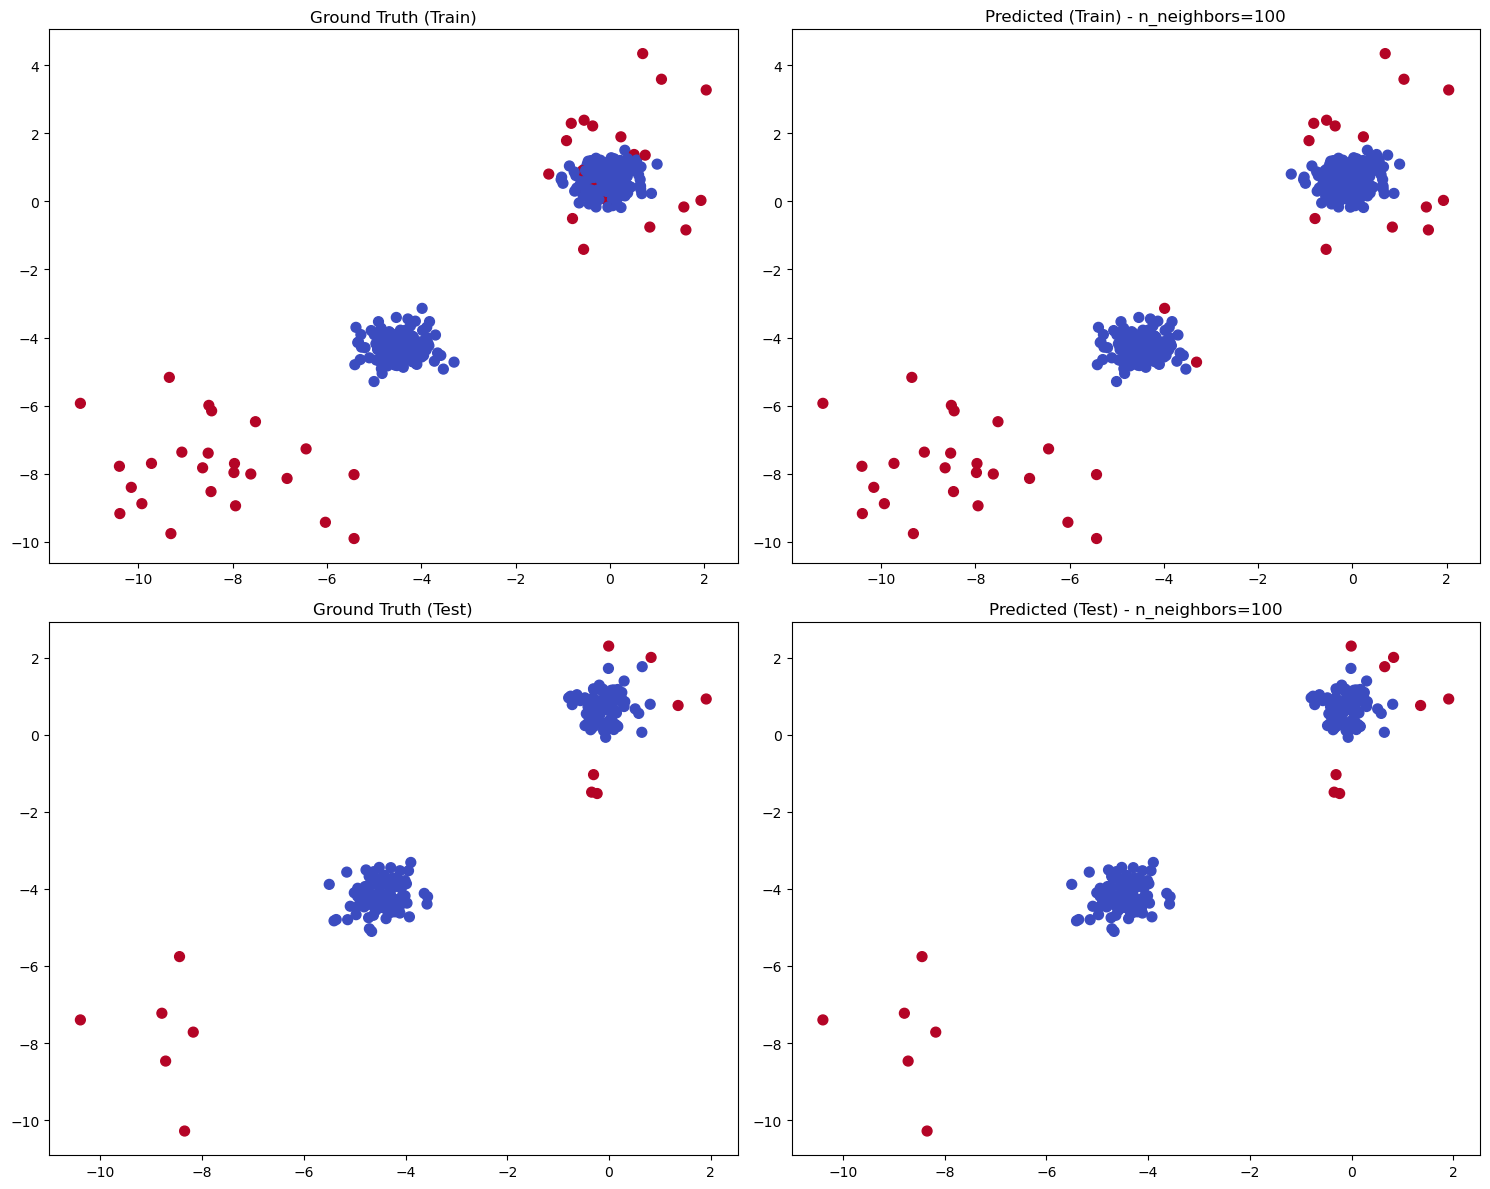

In [3]:
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN 
from sklearn.metrics import balanced_accuracy_score 

X_train, X_test, y_train, y_test = generate_data_clusters(n_train=400, 
                                                          n_test=200, 
                                                          n_clusters=2,
                                                          n_features=2, 
                                                          contamination=0.1)

def plot_results(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, n_neighbors):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    axes[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', s=50)
    axes[0, 0].set_title('Ground Truth (Train)')
    
    axes[0, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train_pred, cmap='coolwarm', s=50)
    axes[0, 1].set_title(f'Predicted (Train) - n_neighbors={n_neighbors}')
    
    axes[1, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', s=50)
    axes[1, 0].set_title('Ground Truth (Test)')
    
    axes[1, 1].scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm', s=50)
    axes[1, 1].set_title(f'Predicted (Test) - n_neighbors={n_neighbors}')
    
    plt.tight_layout()
    plt.show()

k_list = [3, 5, 10, 50, 100]
for k in k_list:
    clf = KNN(n_neighbors=k)
    clf.fit(X_train)

    y_train_pred = clf.labels_  # 0 - inliers, 1 - outliers
    y_train_scores = clf.decision_scores_ 

    y_test_pred = clf.predict(X_test) 
    y_test_scores = clf.decision_function(X_test) 
    plot_results(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, k)
    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f"Balanced accuracy for {k} neighbors: {bal_acc}")


Ex. 3
In this exercise we will see the limitations of distance based algorithms like
KNN. Specifically, we will observe how KNN behaves when our data clusters
have different densities and how pyod.models.lof.LOF solves the problem by
considering the variations of the local densities of the datapoints. First, generate
2 clusters (200 and 100 samples respectively) with 2-dimensional samples using
(-10, -10) and (10, 10) as centers, 2 and 6 as standard deviations using
sklearn.datasets.make blobs() function. Then, fit KNN and LOF with the
generated data using a small contamination rate (0.07) and find the predicted
labels. Use 2 subplots to plot (using different colors for inliers and outliers) the
2 clusters and observe how the 2 models behave for different n neighbors.

In [36]:
from sklearn.datasets import make_blobs
from pyod.models.lof import LOF

X, y = make_blobs(n_samples=[200, 100], n_features=2, centers=[[-10,-10], [10, 10]], cluster_std=[2.0, 6.0])
clf = LOF()
clf.fit(X_train)


(300,)


Ex. 4
For this exercise we will need the cardio dataset from ODDS (https://odds.cs.
stonybrook.edu/cardiotocogrpahy-dataset/). Load the data using scipy.io.loadmat()
and use train test split() to split it into train and test subsets. Normalize
your data accordingly. You will use an ensemble of classifiers of the same
type (KNN or LOF) in order to create an average/maximization strategy
(average/maximum score will be returned). Create 10 KNN/LOF models
for which you vary parameter n neighbors from 30 to 120 (here you can use
other intervals/steps if you observe that they produce better results). Fit each
model, print the balanced accuracy (BA) for train/test data and store both the
train and test scores in order to use them later. Normalize both scores using
pyod.utils.utility.standardizer() and use pyod.models.combination.average()
and pyod.models.combination.maximization() to find the final scores for
the 2 strategies. For each of them find the threshold used for classification
(using numpy.quantile() with the known contamination rate of the dataset),
compute the predictions and print the balanced accuracy (BA)